Tested only on google colab. If there is an error with numpy you should restart the kernel. It is okay

The part of the code is taken from the official documentation of NIR

In [ ]:
!pip install nirtorch norse snntorch tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 618.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s

In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
import tonic.transforms as transforms
import norse
import tonic
from tonic import DiskCachedDataset
from tonic.collation import PadTensors

# Hyperparameters
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

  0%|          | 0/700096 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_train.tar.gz to ./data/POKERDVS


  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_test.tar.gz to ./data/POKERDVS
[(    0, 27, 13, 0) (   39,  5, 22, 1) (   69, 22, 12, 0) ...
 (13560, 20, 13, 0) (13572, 10, 17, 1) (13572, 10,  6, 1)]


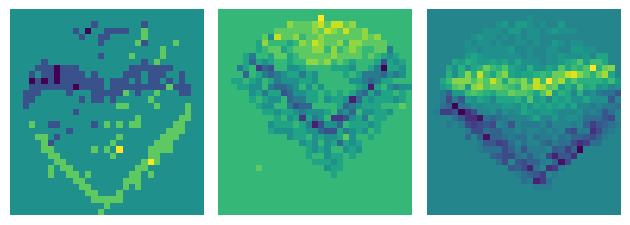

In [ ]:
poker_train = tonic.datasets.POKERDVS(save_to='./data', train=True)
poker_test = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = poker_train[0]
print(events)
tonic.utils.plot_event_grid(events)

In [ ]:
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                            tonic.transforms.ToFrame(
                                            sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                            time_window=1000)
                                            ])

cached_trainset = DiskCachedDataset(poker_train, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(poker_test, transform=frame_transform, cache_path='./cache/pokerdvs/test')

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

data, targets = next(iter(train_loader))
print(data.size())
print(targets)

torch.Size([29, 8, 2, 35, 35])
tensor([2, 1, 3, 0, 0, 2, 2, 1])


In [ ]:
num_inputs = 2 * 35 * 35
num_hidden = 128
num_outputs = 4

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        alpha1 = 0.5
        beta1 = 0.9 # global decay rate for all leaky neurons in layer 1
        beta2 = torch.rand((num_outputs), dtype = torch.float) # independent decay rate for each leaky neuron in layer 2: [0, 1)
        threshold2 = torch.ones_like(beta2) # threshold parameter must have the same shape as beta for NIR
        alpha2 = torch.ones_like(beta2)*0.9

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Synaptic(alpha=alpha1, beta=beta1) # not a learnable decay rate
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Synaptic(alpha=alpha2, beta=beta2, threshold=threshold2, learn_beta=True) # learnable decay rate

    def forward(self, x):
        syn1, mem1 = self.lif1.init_synaptic() # reset/init hidden states at t=0
        syn2, mem2 = self.lif2.init_synaptic() # reset/init hidden states at t=0

        spk2_rec = [] # record output spikes
        mem2_rec = [] # record output hidden states

        for step in range(x.size(0)): # loop over time
            cur1 = self.fc1(x[step].flatten(1))
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2) # record spikes
            mem2_rec.append(mem2) # record membrane

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/usr/local/lib/python3.11/dist-packages/torch/utils/_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = model(data)
print(mem_rec.size())

torch.Size([25, 8, 4])


In [ ]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data, targets in tqdm(test_loader):
            data, targets = data.to(device), targets.to(device)
            spk_rec, _ = model(data)
            spike_count = spk_rec.sum(0)
            _, max_spike = spike_count.max(1)

            total += targets.size(0)
            correct += (max_spike == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
from tqdm import tqdm

In [ ]:
num_epochs = 1
def train(epoch):
    model.train()
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        data, targets = data.to(device), targets.to(device)

        spk_rec, mem_rec = model(data)
        # Sum spikes over time
        loss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(mem_rec.size(0)):
            loss += criterion(mem_rec[step], targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
for epoch in range(num_epochs):
    train(epoch)
    test()

2it [00:00,  4.65it/s]

Epoch 0, Batch 0, Loss: 29.5352


6it [00:01,  4.41it/s]
100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

Test Accuracy: 85.00%


In [ ]:
from snntorch.export_nir import export_to_nir
import nir

In [ ]:
nir_graph = export_to_nir(model.cpu(), data.cpu())
nir.write("nir_model.nir", nir_graph)

In [ ]:
nir_model = nir.read("nir_model.nir")

In [ ]:
norse_model = norse.torch.from_nir(nir_graph, dt=0.0001)

In [ ]:
def apply(data):
    state = None
    hid_rec = []
    out = []

    for i, t in enumerate(data):
        z, state = norse_model(t.flatten(1), state)
        out.append(z)
        hid_rec.append(state)
    spk_out = torch.stack(out)
    return spk_out, hid_rec

In [ ]:
def measure_accuracy2(model, dataloader):
  with torch.no_grad():
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      num_correct = (max_spike == targets).sum()

      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()

In [ ]:
measure_accuracy2(apply, test_loader)

0.8999999761581421